In [2]:
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from glob import glob
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

/users/bangya/miniconda3/envs/vggt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)


In [8]:
import os
# Load and preprocess example images (replace with your own image paths)
# image_names = glob("airsim_single/rgb/*.png")  # Replace with your image paths
image_names_ori = [
    "000120_camera0.png", "000124_camera0.png", "000128_camera0.png", "000132_camera0.png", "000136_camera0.png", "000140_camera0.png",
    "000120_camera3.png", "000124_camera3.png", "000128_camera3.png", "000132_camera3.png", "000136_camera3.png", "000140_camera3.png"
               ]
image_names = [os.path.join("data/opv2v/2021_08_18_09_02_56/440", img_name) for img_name in image_names_ori]
# image_names += [os.path.join("data/opv2v/2021_08_18_09_02_56/449", img_name) for img_name in image_names_ori]
images = load_and_preprocess_images(image_names).to(device)

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        images = images[None]  # add batch dimension
        aggregated_tokens_list, ps_idx = model.aggregator(images)
                
    # Predict Cameras
    pose_enc = model.camera_head(aggregated_tokens_list)[-1]
    # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
    # extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])


In [10]:
tum_t_quat = pose_enc.squeeze(0)[:, :7] # xyz qx qy qz qw
print(f"shape of tum_t_quat: {tum_t_quat.shape}")
pred_pose = "pred_pose.txt"
with open(pred_pose, "w") as f:
    for i in range(tum_t_quat.shape[0]):
        t = tum_t_quat[i, 0:3].cpu().numpy()
        q = tum_t_quat[i, 3:].cpu().numpy()
        f.write(f"{i} {t[0]} {t[1]} {t[2]} {q[0]} {q[1]} {q[2]} {q[3]}")
        f.write("\n") if i != tum_t_quat.shape[0] - 1 else f.write("")


shape of tum_t_quat: torch.Size([12, 7])


Text(0.5, 0.92, 'Camera Trajectory')

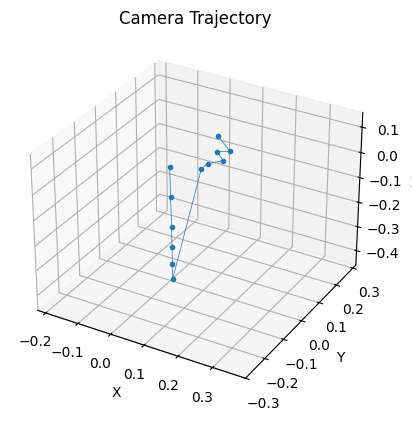

In [11]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import numpy as np
# %matplotlib inline
# %matplotlib widget

tum_t = tum_t_quat[:, 0:3].cpu().numpy()
# plot in interactive 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# same scaling for all axes
max_range = np.array([tum_t[:, 0].max()-tum_t[:, 0].min(), tum_t[:, 1].max()-tum_t[:, 1].min(), tum_t[:, 2].max()-tum_t[:, 2].min()]).max() / 2.0
mid_x = (tum_t[:, 0].max()+tum_t[:, 0].min()) * 0.5
mid_y = (tum_t[:, 1].max()+tum_t[:, 1].min()) * 0.5
mid_z = (tum_t[:, 2].max()+tum_t[:, 2].min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.plot(tum_t[:, 0], tum_t[:, 1], tum_t[:, 2], marker='o', markersize=3, linewidth=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Camera Trajectory')

# print(json.dumps(image_names, indent=2))

